# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
# import frnn
import wandb

sys.path.append('../..')

from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
import copy
from LightningModules.Embedding.utils import build_edges, graph_intersection

device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In [2]:
with open("example_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [3]:
model = LayerlessEmbedding(hparams)

## The Dataset

In [39]:
%%time
model.setup(stage="fit")

CPU times: user 5.84 s, sys: 5.05 s, total: 10.9 s
Wall time: 13.6 s


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [14]:
trainset = model.trainset

In [15]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [43]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

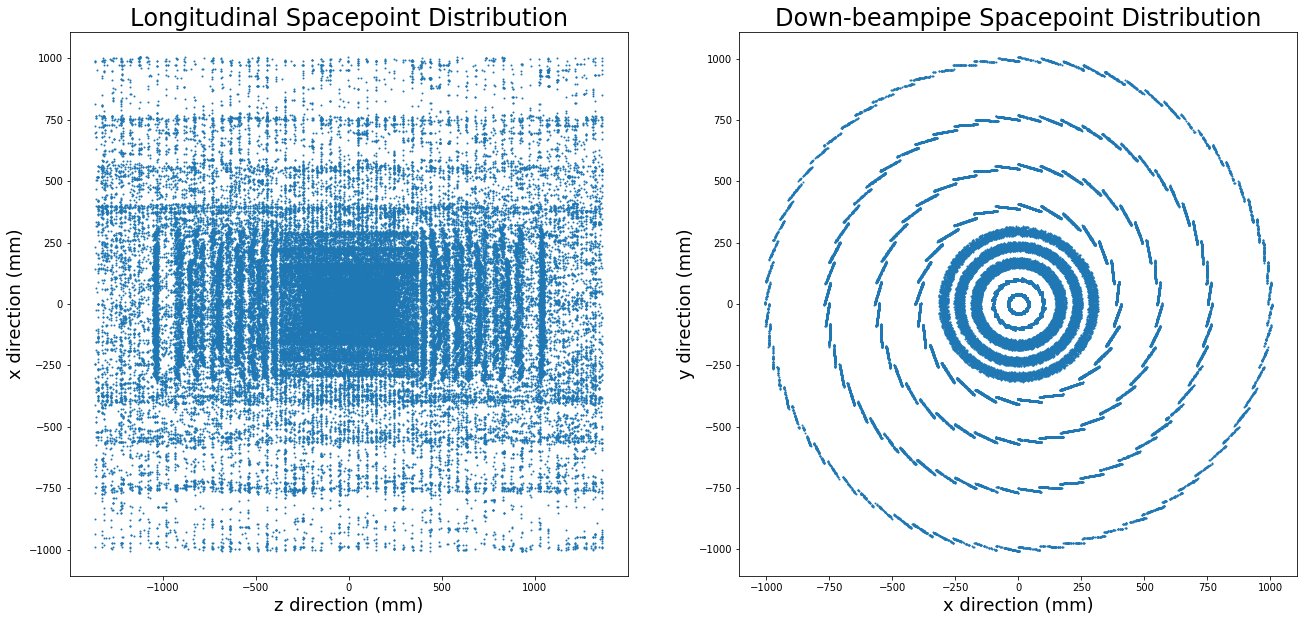

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

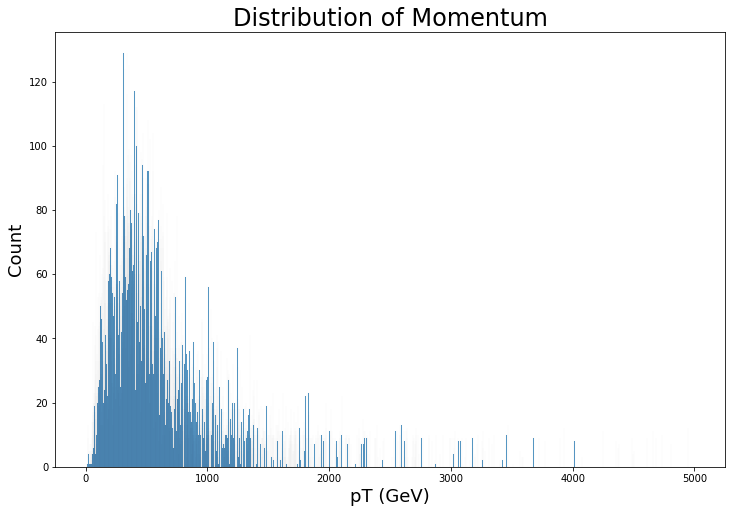

In [45]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.pt == example_data.pt], binwidth=500, binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

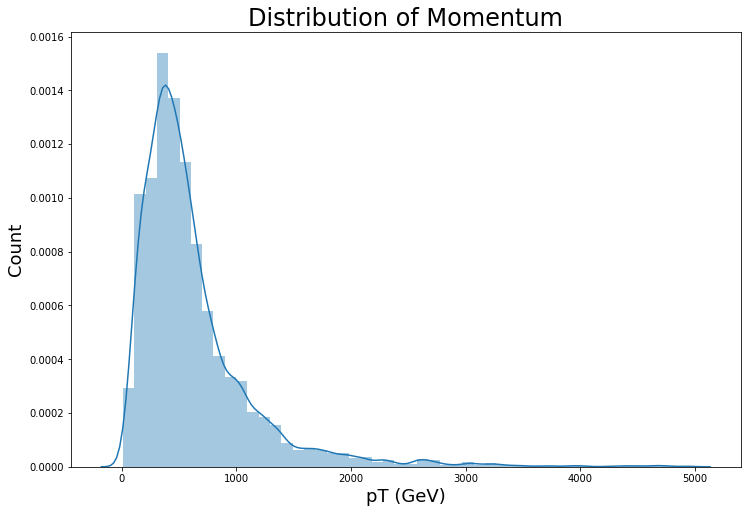

In [46]:
plt.figure(figsize=(12,8))
sns.distplot(example_data.pt[(example_data.pt == example_data.pt) & (example_data.pt < 5000)])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [47]:
particle_count_list = [np.unique(sample.pid.numpy(), return_counts = True)[1][1:] for sample in trainset]

In [48]:
particle_counts = np.concatenate(particle_count_list)

In [49]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

Number of particles: 8130


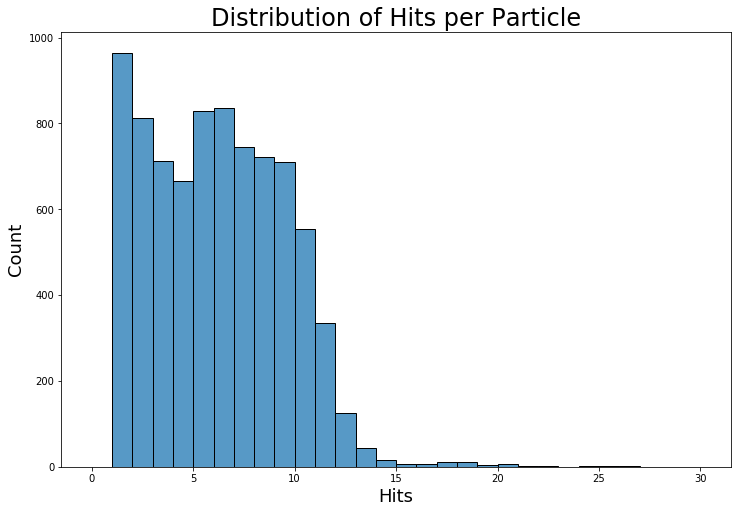

In [50]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[1:], binwidth=1, binrange=[0, 30])
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)
print("Number of particles:", len(particle_num))

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Cell Info

In [20]:
cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
            "pixel"
        ]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

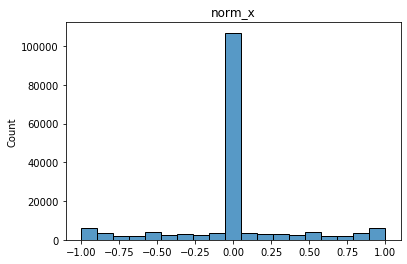

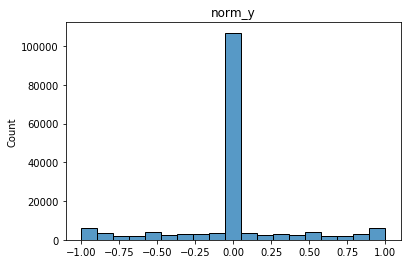

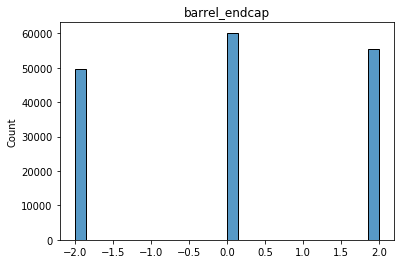

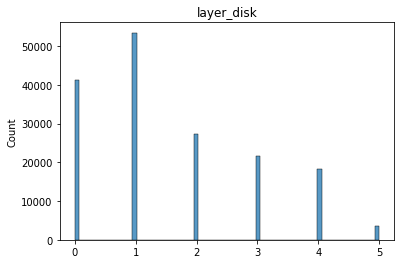

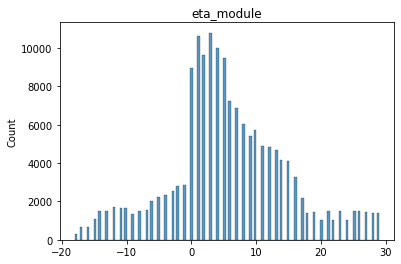

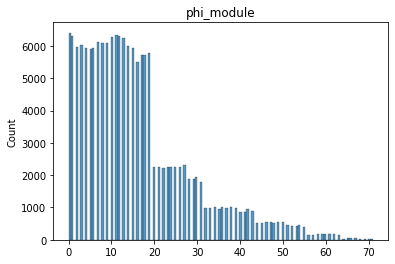

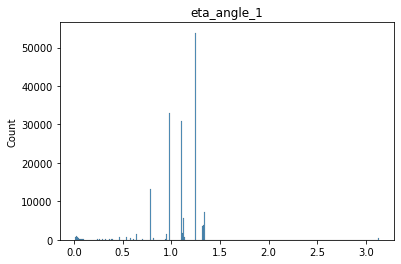

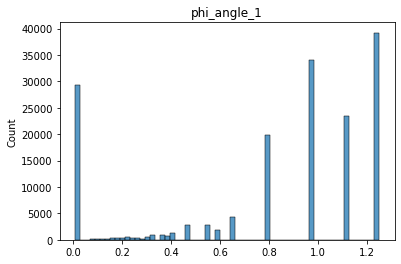

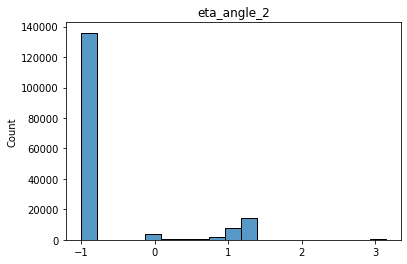

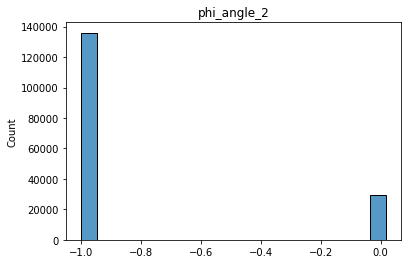

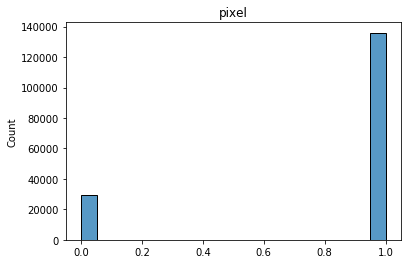

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='eff',
    mode="max",
    save_top_k=2,
    save_last=True)

In [ ]:
logger = WandbLogger(project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"])
trainer = Trainer(gpus=4, max_epochs=hparams["max_epochs"], logger=logger, num_sanity_val_steps=0, callbacks=[checkpoint_callback])
trainer.fit(model)

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:523: UserWarning: You requested multiple GPUs but did not specify a backend, e.g. `Trainer(accelerator="dp"|"ddp"|"ddp2")`. Setting `accelerator="ddp_spawn"` for you.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)


initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/4
initializing ddp: GLOBAL_RANK: 1, MEMBER: 2/4
initializing ddp: GLOBAL_RANK: 2, MEMBER: 3/4
initializing ddp: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All DDP processes registered. Starting ddp with 4 processes
----------------------------------------------------------------------------------------------------

Set SLURM handle signals.
Set SLURM handle signals.
Set SLURM handle signals.
Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 5.3 M 
---------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.123    Total estimated model params size (MB)
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:73: UserWarning: num_workers>0, persistent_

Epoch 0:   0%|          | 0/257 [00:00<?, ?it/s] 

[W reducer.cpp:1050] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters. This flag results in an extra traversal of the autograd graph every iteration, which can adversely affect performance. If your model indeed never has any unused parameters, consider turning this flag off. Note that this warning may be a false positive your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1050] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters. This flag results in an extra traversal of the autograd graph every iteration, which can adversely affect performance. If your model indeed never has any unused parameters, consider turning this flag off. Note that this warning may be a false positive your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1050] Warning

Epoch 0:  19%|█▉        | 50/257 [01:01<04:13,  1.22s/it, loss=0.1, v_num=nu83]  

wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.6
wandb: Syncing run bright-bush-6
wandb:  View project at https://wandb.ai/murnanedaniel/ITk_1GeVSignal_Embedding
wandb:  View run at https://wandb.ai/murnanedaniel/ITk_1GeVSignal_Embedding/runs/333l76cv
wandb: Run data is saved locally in /global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/wandb/run-20211112_145747-333l76cv
wandb: Run `wandb offline` to turn off syncing.



Epoch 0:  97% 250/257 [04:50<00:08,  1.16s/it, loss=0.0993, v_num=76cv]        
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/7 [00:00<?, ?it/s]Average nbhood: 499.67921964888444

Epoch 0:  98% 252/257 [05:03<00:06,  1.20s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.74680592639663

Epoch 0:  98% 253/257 [05:15<00:04,  1.25s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.67517548195747

Epoch 0:  99% 254/257 [05:25<00:03,  1.28s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.5563438475555

Epoch 0:  99% 255/257 [05:34<00:02,  1.31s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.5001583039201

Epoch 0: 100% 256/257 [05:42<00:01,  1.34s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.6497134807468

Epoch 0: 100% 257/257 [05:51<00:00,  1.37s/it, loss=0.0993, v_num=76cv]Average nbhood: 499.58949130138154

Epoch 0: 100% 257/257 [05:59<00:00,  1.40s/it, loss=0.0993, v_num=76cv]
Epoch 1:   0% 0/257 [00:00<?, ?it/s, loss=0.0993, v_num=76cv]          

/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:279: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Seems like `optimizer.step()` has been overridden after learn

Average nbhood: 499.57517520747075
Average nbhood: 499.7066889164728
Average nbhood: 499.7258475867637
Average nbhood: 499.57202661936816
Average nbhood: 499.56193528514433
Average nbhood: 499.6613681019728
Average nbhood: 499.68019008397295
Average nbhood: 499.6706207768844
Average nbhood: 499.6571392976719
Average nbhood: 499.6348294710395
Average nbhood: 499.66064776410883
Average nbhood: 499.6484011814563
Average nbhood: 499.49021792020716
Average nbhood: 499.57554085784443
Average nbhood: 499.62519611121115
Average nbhood: 499.583119459512
Average nbhood: 499.64981951711076
Average nbhood: 499.45263367495386
Average nbhood: 499.63192190017986
Average nbhood: 499.657410305803
Average nbhood: 499.6709431228261


/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:279: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)
/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Seems like `optimizer.step()` has been overridden after learn

Epoch 1:  97% 250/257 [04:41<00:07,  1.13s/it, loss=0.0989, v_num=76cv]
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/7 [00:00<?, ?it/s]Average nbhood: 498.3821209465381

Epoch 1:  98% 252/257 [04:55<00:05,  1.17s/it, loss=0.0989, v_num=76cv]Average nbhood: 498.9155831842851

Epoch 1:  98% 253/257 [05:08<00:04,  1.22s/it, loss=0.0989, v_num=76cv]Average nbhood: 498.66990749240875

Epoch 1:  99% 254/257 [05:19<00:03,  1.26s/it, loss=0.0989, v_num=76cv]Average nbhood: 497.7719230714901

Epoch 1:  99% 255/257 [05:28<00:02,  1.29s/it, loss=0.0989, v_num=76cv]Average nbhood: 496.9533374765964

Epoch 1: 100% 256/257 [05:36<00:01,  1.32s/it, loss=0.0989, v_num=76cv]Average nbhood: 498.2590401764372

Epoch 1: 100% 257/257 [05:47<00:00,  1.35s/it, loss=0.0989, v_num=76cv]Average nbhood: 497.53838336460285

Epoch 1: 100% 257/257 [05:55<00:00,  1.38s/it, loss=0.0989, v_num=76cv]
Epoch 2:   0% 0/257 [00:00<?, ?it/s, loss=0.0989, v_num=76cv]          Average nbhood: 497.66345109426254
Average n

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.270412834605837 seconds), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.076171851671498 seconds), retrying request


Epoch 31:  56% 143/257 [01:44<01:22,  1.37it/s, loss=0.0951, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.178034234829445 seconds), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.466554874191973 seconds), retrying request


Epoch 31:  58% 150/257 [01:49<01:17,  1.37it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 9.091927937591942 seconds), retrying request


Epoch 31:  64% 165/257 [01:59<01:06,  1.38it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 16.02708354930043 seconds), retrying request


Epoch 31:  67% 171/257 [02:04<01:02,  1.38it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.1030381110602567 seconds), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.785881614228317 seconds), retrying request


Epoch 31:  97% 250/257 [03:00<00:05,  1.38it/s, loss=0.0951, v_num=76cv]
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/7 [00:00<?, ?it/s]Average nbhood: 50.55637469711811

Epoch 31:  98% 252/257 [03:04<00:03,  1.37it/s, loss=0.0951, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.0578991751697746 seconds), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.327657616395791 seconds), retrying request


Average nbhood: 60.00869689996772

Validating:  29% 2/7 [00:04<00:11,  2.30s/it]Average nbhood: 54.45899583362757

Epoch 31:  99% 254/257 [03:06<00:02,  1.36it/s, loss=0.0951, v_num=76cv]Average nbhood: 43.786751514980295

Validating:  57% 4/7 [00:06<00:04,  1.40s/it]Average nbhood: 40.62800142278091

Epoch 31: 100% 256/257 [03:08<00:00,  1.36it/s, loss=0.0951, v_num=76cv]Average nbhood: 49.29083457098602

Validating:  86% 6/7 [00:08<00:01,  1.08s/it]Average nbhood: 45.37552589686736

Epoch 31: 100% 257/257 [03:10<00:00,  1.35it/s, loss=0.0951, v_num=76cv]
                                             Average nbhood: 43.448140381065045
Average nbhood: 55.80587318158527
Average nbhood: 57.74755521811892
Average nbhood: 44.97779391637105
Average nbhood: 43.244675545646565
Average nbhood: 54.01598996061426
Average nbhood: 50.55637469711811
Average nbhood: 51.834289626293604
Average nbhood: 51.58422175504165
Average nbhood: 48.904531847218884
Average nbhood: 51.0815658737714
Average nbhood:

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.3940301286564725 seconds), retrying request


Epoch 32:  12% 30/257 [00:23<03:01,  1.25it/s, loss=0.0951, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.662023428271141 seconds), retrying request


Epoch 32:  18% 45/257 [00:34<02:42,  1.31it/s, loss=0.0948, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.3021030103713787 seconds), retrying request


Epoch 32:  20% 52/257 [00:39<02:34,  1.33it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.738583206215025 seconds), retrying request


Epoch 32:  26% 66/257 [00:49<02:22,  1.34it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.2171703439672434 seconds), retrying request


Epoch 32:  28% 72/257 [00:53<02:18,  1.34it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.460775511768965 seconds), retrying request


Epoch 32:  34% 87/257 [01:04<02:06,  1.35it/s, loss=0.0951, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.27187537782654 seconds), retrying request


Epoch 32:  37% 94/257 [01:09<02:00,  1.35it/s, loss=0.0951, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.039819639410455 seconds), retrying request


Epoch 32:  39% 101/257 [01:14<01:55,  1.35it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 9.836580687169514 seconds), retrying request


Epoch 32:  42% 108/257 [01:19<01:49,  1.36it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.327068411991944 seconds), retrying request


Epoch 32:  45% 115/257 [01:24<01:44,  1.36it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 17.310650393271633 seconds), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.154081538049228 seconds), retrying request


Epoch 32:  53% 136/257 [01:39<01:28,  1.36it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 37.952596138271595 seconds), retrying request


Epoch 32:  58% 150/257 [01:49<01:18,  1.36it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.073330171534211 seconds), retrying request


Epoch 32:  61% 156/257 [01:54<01:14,  1.36it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.972158311632896 seconds), retrying request


Epoch 32:  75% 192/257 [02:20<00:47,  1.37it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.4880407210744693 seconds), retrying request


Epoch 32:  77% 199/257 [02:24<00:42,  1.37it/s, loss=0.0948, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.870937491067331 seconds), retrying request


Epoch 32:  91% 235/257 [02:50<00:15,  1.38it/s, loss=0.0949, v_num=76cv]

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.4598098734484033 seconds), retrying request


Epoch 32:  94% 242/257 [02:55<00:10,  1.38it/s, loss=0.095, v_num=76cv] 

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.686185817842089 seconds), retrying request


Epoch 32:  97% 250/257 [03:01<00:05,  1.38it/s, loss=0.095, v_num=76cv] 
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/7 [00:00<?, ?it/s]Average nbhood: 50.67526512589879

Epoch 32:  98% 252/257 [03:04<00:03,  1.36it/s, loss=0.095, v_num=76cv]Average nbhood: 60.16979710649987

Validating:  29% 2/7 [00:04<00:11,  2.30s/it]Average nbhood: 54.64415224913495

Epoch 32:  99% 254/257 [03:07<00:02,  1.35it/s, loss=0.095, v_num=76cv]Average nbhood: 43.82457305100787

Validating:  57% 4/7 [00:06<00:04,  1.40s/it]Average nbhood: 40.719536267232655

Epoch 32: 100% 256/257 [03:09<00:00,  1.35it/s, loss=0.095, v_num=76cv]Average nbhood: 49.39444681705475

Validating:  86% 6/7 [00:08<00:01,  1.08s/it]Average nbhood: 45.45551907442152

Epoch 32: 100% 257/257 [03:10<00:00,  1.35it/s, loss=0.095, v_num=76cv]
                                             Average nbhood: 51.94580290234146
Average nbhood: 51.68892003425991
Average nbhood: 48.966595835672095
Average nbhood: 51.13674305846774
Average nbh

### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [ ]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

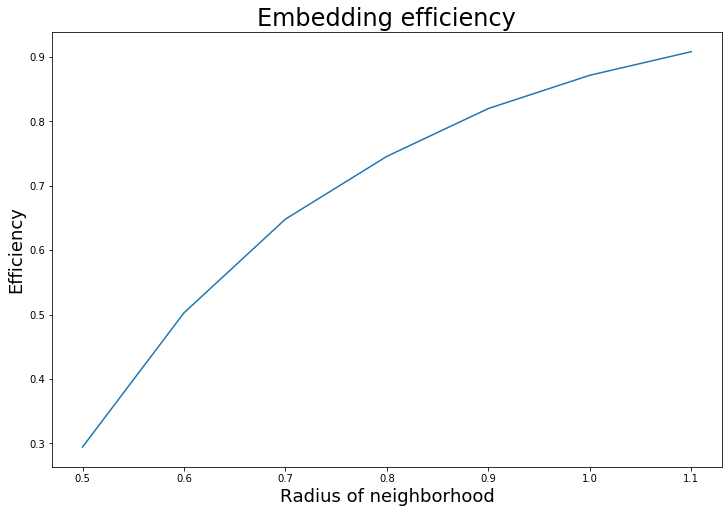

In [28]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);

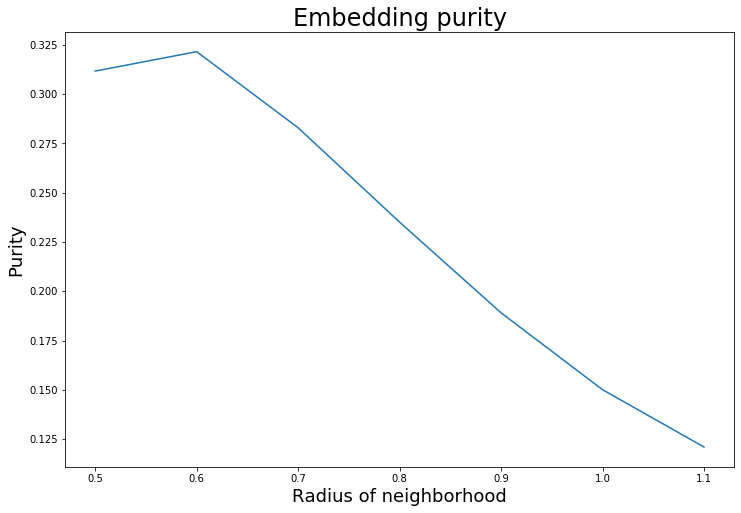

In [29]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

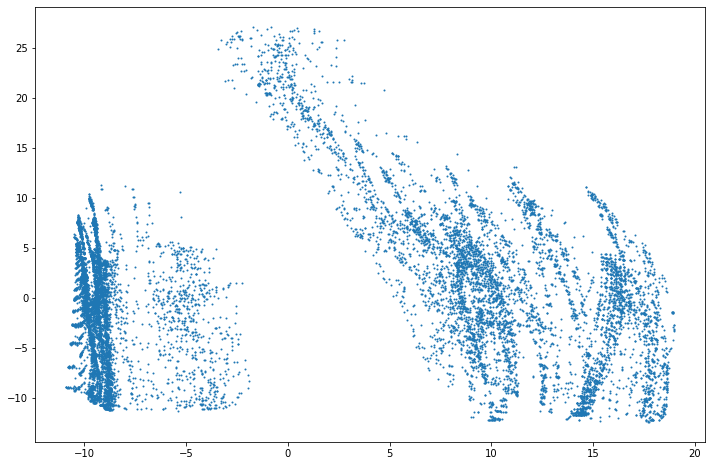

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

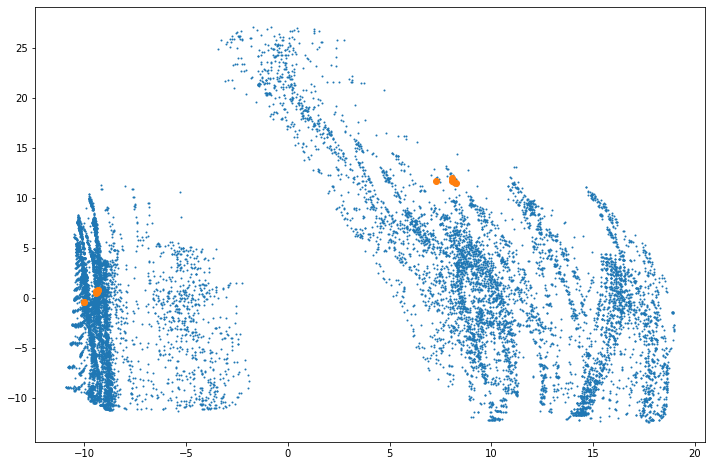

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(reduced_dimensions[particle_ids == example_particle, 0], reduced_dimensions[particle_ids == example_particle, 1])

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

### Distributions

In [7]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [6]:
def get_performance(model, batch, r_max, k_max):
    with torch.no_grad():
        results = model.shared_evaluation(batch, 0, r_max, k_max)
    
    return results["truth"], results["preds"], results["truth_graph"]

In [7]:
r_max = 0.4
k_max = 2000

In [8]:
%%time
batch = 0
model.eval()

y_cluster, e_spatial, e_bidir = get_performance(model, model.testset[batch].to(device), r_max=r_max, k_max=k_max)

Average nbhood: 54.47683273347225
CPU times: user 575 ms, sys: 5.27 ms, total: 580 ms
Wall time: 96.7 ms


/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/embedding_base.py:279: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)


In [9]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025037623941898346, Eff: 0.9926109910011292


In [44]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025036856532096863, Eff: 0.9926661252975464


In [45]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.025036856532096863, Eff: 0.9926661252975464


In [12]:
eta_cuts = np.arange(-4, 4.5, 0.5)
batch_range = np.arange(0,200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in batch_range[:5]:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=r_max, k_max=k_max)
    
    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[e_spatial[0]] + eta_hits[e_spatial[1]])/2
    av_eta_true = (eta_hits[e_bidir[0]] + eta_hits[e_bidir[1]])/2
    
    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_true = (av_eta_true >= eta1) & (av_eta_true <= eta2)
        true_positives = y_cluster[edge_eta_pred]

        eta_eff_list.append(true_positives.sum().item() / edge_eta_true.sum().item())
        eta_pur_list.append(true_positives.sum().item() / true_positives.shape[0])

RuntimeError: CUDA out of memory. Tried to allocate 1.52 GiB (GPU 0; 15.78 GiB total capacity; 11.62 GiB already allocated; 1.49 GiB free; 12.93 GiB reserved in total by PyTorch)

In [ ]:
eta_eff_reshape = np.array(eta_eff_list).reshape(eta_cuts.shape[0]-1, len(batch_range))
eta_pur_reshape = np.array(eta_pur_list).reshape(eta_cuts.shape[0]-1, len(batch_range))

Train set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

Test set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_eff_reshape.mean(1), eta_eff_reshape.std(1), fmt="o")

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_pur_reshape.mean(1), eta_pur_reshape.std(1), fmt="o")

In [ ]:
pt_cuts = np.arange(900, 5000, 500)

pt_eff_list = []
pt_pur_list = []
    
for batch_idx in batch_range:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=1.2, k_max=500)
    
    av_pt_preds = (batch.pt[e_spatial[0]] + batch.pt[e_spatial[1]])/2
    av_pt_true = (batch.pt[e_bidir[0]] + batch.pt[e_bidir[1]])/2
    
    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        true_positives = y_cluster[edge_pt_pred]

        pt_eff_list.append(true_positives.sum().item() / max(1, edge_pt_true.sum().item()))
        pt_pur_list.append(true_positives.sum().item() / max(1, true_positives.shape[0]))
    

In [ ]:
pt_eff_reshape = np.array(pt_eff_list).reshape(pt_cuts.shape[0]-1, len(batch_range))
pt_pur_reshape = np.array(pt_pur_list).reshape(pt_cuts.shape[0]-1, len(batch_range))

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_eff_reshape.mean(1), pt_eff_reshape.std(1), fmt="o")

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_pur_reshape.mean(1), pt_pur_reshape.std(1), fmt="o")

## Memory of Edge Builder

In [29]:
torch.cuda.max_memory_allocated() / 1024**3

4.934445381164551

In [26]:
torch.cuda.reset_peak_memory_stats()

In [8]:
r_max = 1.6
k_max = 1000

In [9]:
batch = model.testset[0].to(device)
model.eval()
with torch.no_grad():
    input_data = torch.cat([batch.cell_data[:, :model.hparams["cell_channels"]], batch.x], axis=-1)
    input_data[input_data != input_data] = 0
    spatial = model(input_data)
    e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )

In [11]:
dists, idxs, nn, grid = frnn.frnn_grid_points(points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=k_max, r=r_max, grid=None, return_nn=False, return_sorted=True)

In [13]:
idxs = idxs.squeeze().int()
ind = torch.Tensor.repeat(torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1).T.int()

In [15]:
positive_idxs = idxs >= 0
ind = ind[positive_idxs]
idxs = idxs[positive_idxs]

In [17]:
edge_list = torch.stack([ind, idxs]).int()

In [19]:
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

In [24]:
del ind
del idxs

In [28]:
edge_list = edge_list.long()

# Build Edge Dataset

## Load best model

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Embedding//checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

In [4]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [5]:
model.hparams["train_split"] = [8000, 100, 100]
# model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel"

In [6]:
%%time
model.setup(stage="fit")

CPU times: user 1h 52min 56s, sys: 33 s, total: 1h 53min 29s
Wall time: 12min 6s


## Define Building Class

In [ ]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]


    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.model.trainset,
            "val": self.model.valset,
            "test": self.model.testset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for batch_idx, batch in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        input_data = self.model.get_input_data(batch)
        
        spatial = self.model(input_data)

        # Make truth bidirectional
        e_bidir = torch.cat(
            [batch.signal_true_edges, batch.signal_true_edges.flip(0)], axis=-1,
        )

        # Build the radius graph with radius < r_test
        e_spatial = build_edges(
            spatial, spatial, indices=None, r_max = self.model.hparams.r_test, k_max = 1000
        )  # This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur

        # Arbitrary ordering to remove half of the duplicate edges
        R_dist = torch.sqrt(batch.x[:, 0] ** 2 + batch.x[:, 2] ** 2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

        e_spatial, y_cluster = self.model.get_truth(batch, e_spatial, e_bidir)

        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = (
            e_spatial[1, random_flip],
            e_spatial[0, random_flip],
        )

        batch.edge_index = e_spatial
        batch.y = y_cluster

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)


In [ ]:
output_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/1_GeVSignal"
model.hparams["r_test"] = 0.1
edge_builder = EmbeddingInferenceBuilder(model, output_dir, overwrite=False)

In [ ]:
edge_builder.build()

Training finished, running inference to build graphs...
